In [8]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pyhf

jax.config.update("jax_enable_x64", True)

from maker import yield_maker
from model import simplemodel2
from relaxed import infer

In [9]:
SCALE = 10000

N = 270 * SCALE


def generate_data():
    b1 = np.random.multivariate_normal([+1.0, +0.0], np.eye(2), size=N // 4)
    b2 = np.random.multivariate_normal([+0.0, +0.0], np.eye(2), size=N // 4)
    b3 = np.random.multivariate_normal([-1.0, -0.0], np.eye(2), size=N // 4)

    s1 = np.random.multivariate_normal([3.0, 0.0], np.eye(2), size=N // 16)

    return s1, b1, b2, b3


anchr = jnp.array([0.0, 0.0])
data = generate_data()

In [15]:
model_maker = yield_maker(generate_data, SCALE=SCALE)
hypotest = infer.make_hypotest(model_maker)
hypotest(0.2, test_mu=1.0)


def loss(angle):
    return hypotest(angle, 1.0)["CLs"]

In [21]:
def grad_descent(current_angle, lr=2):
    current_cls, grad = jax.value_and_grad(loss)(current_angle)
    angle = current_angle - grad * lr
    return angle, current_angle, current_cls, grad


x = 0.0
for i in range(50):
    x, current_x, cls, grad = grad_descent(x, lr=8)
    print(cls, current_x)

0.05689532731531499 0.0
0.05683876766778995 0.01193287815516717
0.05310925728573723 0.0994029429261221
0.04852317777446258 0.5494062727388821
0.04778728647915864 0.47046347553245643
0.047328744843311066 0.4047987245277014
0.04715604653870109 0.3607286044763486
0.04713989991621359 0.3465407451552159
0.047138496360982884 0.3423689611411049
0.047138335035023626 0.340932226693426
0.047138311703458724 0.34036676048047365
0.04713831102419985 0.34013325953136686
0.04713831127474544 0.34003626934677683
0.04713831010071434 0.33999542309456005
0.047138310276721995 0.33997739168310553
0.04713831035820615 0.3399697658383085
0.04713831039394223 0.33996653914588587
0.04713831040929439 0.33996517356809036
0.04713831041582983 0.3399645955877571
0.04713831041860539 0.33996435094874444
0.04713831041977823 0.33996424739992015
0.04713831042027894 0.33996420357039947
0.04713831042048877 0.3399641850183501
0.04713831042057781 0.33996417716573085
0.047138310420616 0.3399641738419315
0.04713831042063288 0.339

In [17]:
angles = jnp.linspace(0, jnp.pi / 2.0, 51)
r1 = jax.vmap(loss)(angles)

0.34557519189487723 0.04687543882321976


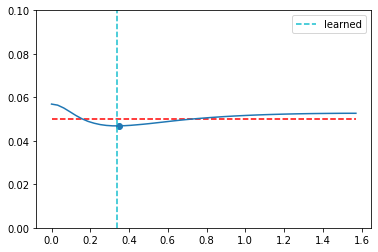

In [25]:
plt.plot(angles, r1)
plt.scatter(angles[np.argmin(r1)], r1[np.argmin(r1)])
print(angles[np.argmin(r1)], r1[np.argmin(r1)])
plt.hlines(0.05, 0, jnp.pi / 2.0, colors="r", linestyles="dashed")
plt.vlines(x, 0, 0.1, linestyles="dashed", colors="C9", label="learned")
plt.ylim(0.0, 0.1)
plt.legend()
# plt.xlim(0, jnp.pi / 2.0)